# Introduction to `darts`
In this notebook, we will go over the main functionalities of the library: how to build and manipulate time series, train forecasting models, make predictions, evaluate metrics, backtest models and ensemble several models.

As a toy example, we will use the well known [monthly airline passengers dataset](https://github.com/jbrownlee/Datasets/blob/master/monthly-airline-passengers.csv).

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    StandardRegressionModel,
    Theta,
    FFT
)
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

## Read data and build a `TimeSeries`
A `TimeSeries` simply represents a univariate or multivariate time series, with a proper time index. It is a wrapper around a `pandas.DataFrame`, and it can be built in a few different ways:
* From an entire Pandas `DataFrame` directly
* From a time index and an array of corresponding values
* From a subset of Pandas `DataFrame` columns, indicating which are the time column and the values columns. This is what we will do here:

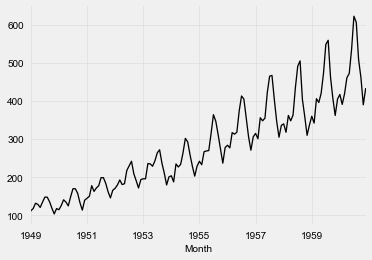

In [3]:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', ['#Passengers'])

series.plot()

## Creating a training and validation series
First, let's split our `TimeSeries` into a training and a validation series. Note: in general, it is also a good practice to keep a test series aside and never touch it until the end of the process. Here, we just build a training and a test series for simplicity.

The training series will be a `TimeSeries` containing values until January 1958 (excluded), and the validation series a `TimeSeries` containing the rest:

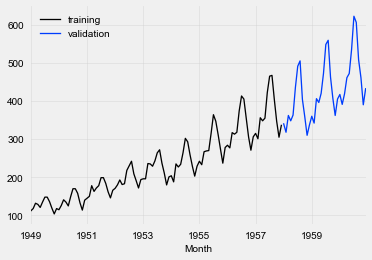

In [4]:
train, val = series.split_before(pd.Timestamp('19580101'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

## Playing with toy models
There is a collection of "naive" baseline models in `darts`, which can be very useful to get an idea of the bare minimum accuracy that one could expect. For example, the `NaiveSeasonal(K)` model always "repeats" the value that occured `K` time steps ago. 

In its most naive form, when `K=1`, this model simply always repeats the last value of the training series:

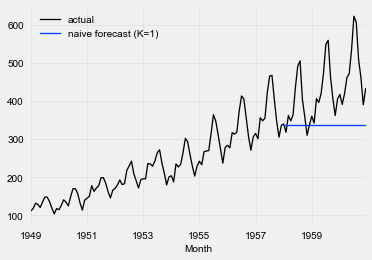

In [5]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label='actual')
naive_forecast.plot(label='naive forecast (K=1)')
plt.legend();

It's very easy to fit models and produce predictions on `TimeSeries`. All the models have a `fit()` and a `predict()` function. This is similar to [https://scikit-learn.org/](https://scikit-learn.org/), except that it is specific to time series. The `fit()` function takes in argument the training time series on which to fit the model, and the `predict()` function takes in argument the number of time steps (after the end of the training series) over which to forecast.

### Inspect Seasonality
Our model above is perhaps a bit too naive. We can already improve by exploiting the seasonality in the data. It seems quite obvious that the data has a yearly seasonality, which we can confirm by looking at the auto-correlation function (ACF), and highlighting the lag `m=12`:

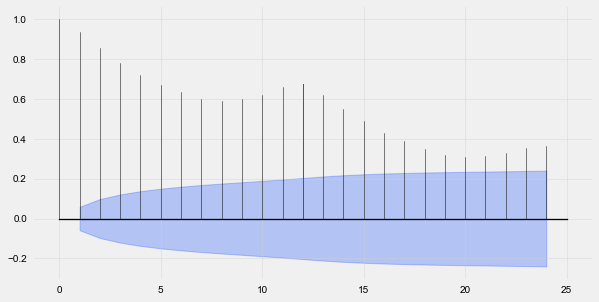

In [6]:
plot_acf(train, m = 12, alpha = .05)

The ACF presents a spike at x = 12, which suggests a yearly seasonality trend (highlighted in red). The blue zone determines the significance of the statistics for a confidence level of alpha = 5%. In cases where we are unsure, we can also run a statistical check of seasonality for each candidate period `m`:

In [7]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=.05)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

There is seasonality of order 12.


### A less naive model
Let's try the `NaiveSeasonal` model again with a seasonality of 12:

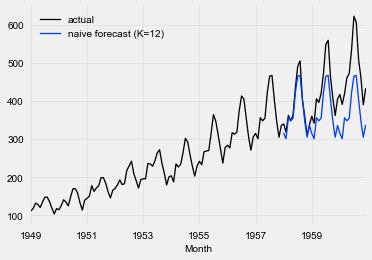

In [8]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=12)')
plt.legend();

This is better, but we are still missing the trend. Fortunately, there is also another naive baseline model capturing the trend, which is called `NaiveDrift`. This model will simply produce linear predictions, with a slope that is determined by the first and last values of the training set:

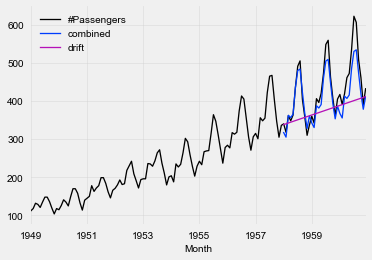

In [9]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
plt.legend();

What happened in the last cell? We simply fit a naive drift model, and add its forecast to the seasonal forecast we had previously. We also substract the last value of the training set to the result, so that the resulting combined forecast starts off with the right offset.

This looks already like a fairly descent forecast, and we did not use any non-naive model yet! In fact - any model should be able to beat this. But hey, what's the error we are getting here? Let's see what we'll have to beat:

In [10]:
print("Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
      mape(series, combined_forecast)))

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


## Quickly try a few more models
`darts` is built to make it easy to train and validate several models in a unified way. Let's train a few more and compute their respective MAPE on the validation set:

In [11]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

model Exponential smoothing obtains MAPE: 6.50%
model Prophet obtains MAPE: 9.72%
model Auto-ARIMA obtains MAPE: 12.56%
model Theta(2) obtains MAPE: 8.15%


Here, we did only built these models with their default parameters. We can probably do better if we fine-tune to our problem. Let's try with the Theta method.

## The Theta method

The model `Theta` contains an implementation of Assimakopoulos and Nikolopoulos' Theta method. This method has known great success, particularly in the M3-competition.

Though the value of the Theta parameter is often set to 0 in applications, our implementation supports a variable value for parameter tuning purposes. Let's try to find a good value for Theta:

In [12]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)
    
    if res < best_mape:
        best_mape = res
        best_theta = theta

In [13]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))

The MAPE is: 4.40, with theta = -3.5102040816326543.


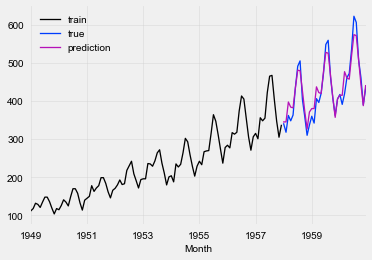

In [14]:
train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')
plt.legend();

We can observe that the model with `best_theta` is so far the best we have, in terms of MAPE.

## Backtesting: simulate historical forecasting
So at this point we have a model that performs well on our validation set, and that's good. But how can we know the performance we *would have obtained* if we *had been using this model* historically. 

Backtesting simulates predictions that would have been obtained historically with a given model. It can take a while to produce, since the model is re-fit every time the simulated prediction time advances.

Such simulated forecasts are always defined with respect to a *forecast horizon*, which is the number of time steps that separate the prediction time from the forecast time. In the example below, we simulate forecasts done for 3 months in the future (compared to prediction time).

Using the `backtest()` method, you can either look at the performance of the model evaluated over the whole forecasts it produces (each point in each forecast is used to compute an average error score) or only the last point of each historical forecast.
In the latter case, you can get a time series representation of those points by calling `historical_forecasts()` and setting `last_points_only=True`

In [15]:
best_theta_model = Theta(best_theta)

average_error = best_theta_model.backtest(series, start=pd.Timestamp('19550101'), forecast_horizon=3, verbose=True)
print("Average error (MAPE) over all historical forecasts: {}".format(average_error))

historical_fcast_theta = best_theta_model.historical_forecasts(series, start=pd.Timestamp('19550101'), forecast_horizon=3, last_points_only=True, verbose=True)


Average error (MAPE) over all historical forecasts: 6.194975107934412


Let's see what this backtest forecast looks like. You can see it produces more accurate predictions at a 3 months horizon than the one-off prediction done above, because here the model is re-fit every month.

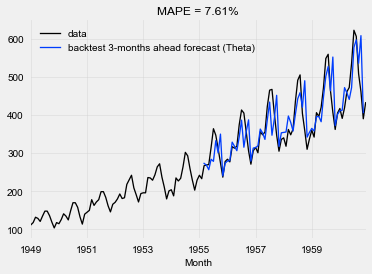

In [16]:
series.plot(label='data')
historical_fcast_theta.plot(label='backtest 3-months ahead forecast (Theta)')
plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_theta, series)))
plt.legend();

Let's look at the fitted value residuals of our current `Theta` model, i.e. the difference between the 1-step forecasts at every point in time obtained by fitting the model on all previous points, and the actual observed values.

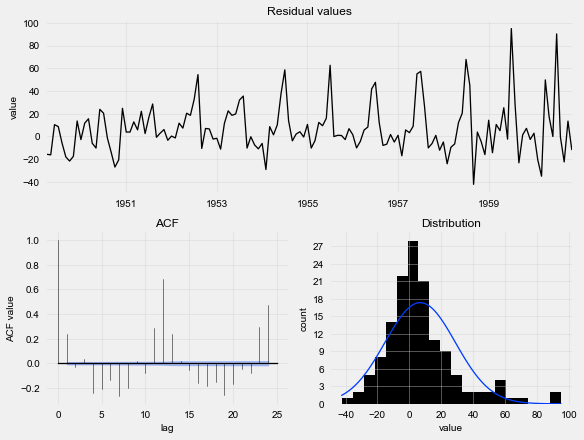

In [17]:
plot_residuals_analysis(best_theta_model.residuals(series))

We can see that the distribution has a mean that is slightly larger than 0. This means that our `Theta` model is biased. We can also make out a large ACF value at lag equal to 12, which indicates that the residuals contain information that was not used by the model.

Could we maybe do better with a simple `ExponentialSmoothing` model?

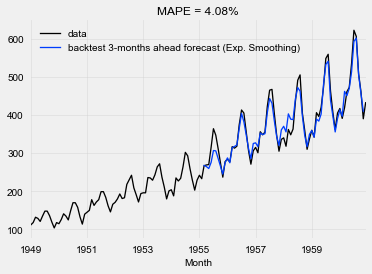

In [18]:
model_es = ExponentialSmoothing()
historical_fcast_es = model_es.historical_forecasts(series, start=pd.Timestamp('19550101'), forecast_horizon=3, last_points_only=True, verbose=True)

series.plot(label='data')
historical_fcast_es.plot(label='backtest 3-months ahead forecast (Exp. Smoothing)')
plt.title('MAPE = {:.2f}%'.format(mape(historical_fcast_es, series)))
plt.legend()
plt.show()

This much better! We get a mean absolute percentage error of 4.08% when backtesting with a 3-months forecast horizon in this case. 

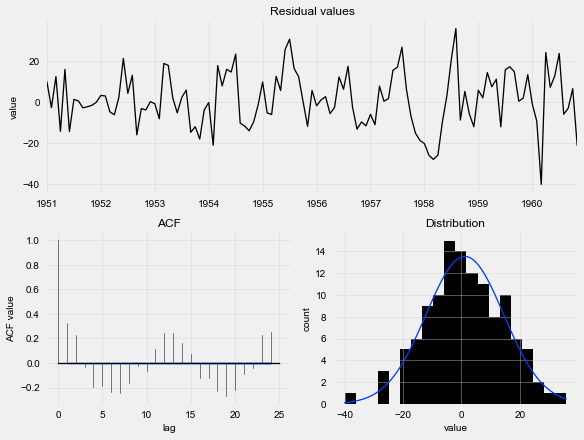

In [19]:
plot_residuals_analysis(model_es.residuals(series))

The residual analysis also reflects an improved performance in that we now have a distribution of the residuals centred at value 0, and the ACF values, although not insignificant, have lower magnitudes.

## Ensembling several predictions
*Ensembling* is about combining the forecasts produced by several models, in order to obtain a final -- and hopefully better forecast.

For instance, in our example of a "less naive" model above, we manually combined a naive seasonal model with a naive drift model. Here, we will try to find such combinations in an automated way, using `RegressionModel`s. A regression model is a model that predicts a *target* time series from a bunch of *features* time series. If the features time series are themselves obtained from forecasting models, their future (predicted) values can be combined using the regression model to obtain a final forecast.

Here, we will first compute the historical predictions two naive seasonal models (with 6 and 12 months seasonality), and naive drift model. To compute the historical forecasts, we can simply reuse the `historical_forecasts()` method:

In [20]:
models = [NaiveSeasonal(6), NaiveSeasonal(12), NaiveDrift()]

model_predictions = [m.historical_forecasts(series, start=pd.Timestamp('19570101'), forecast_horizon=6, last_points_only=True, verbose=True)
                     for m in models]

Now that we have the historical forecasts *that we would have obtained* from a couple of models, we can train a `StandardRegressionModel`, in order to learn in a supervised way how to best combine the features time series (our 3 forecasts) into the target series that we are trying to predict.

By default the `StandardRegressionModel` will fit a linear regression for predicting the target series from some features series. If you want something different than linear regression, `StandardRegressionModel` can wrap around any scikit-learn regression model.

In [21]:
""" We build the regression model, and tell it to use the 12 preceding points to fit the regression
"""
regr_model = StandardRegressionModel(train_n_points=12)

""" Our target series is what we want to predict (the actual data)
    It has to have the same time index as the features series:
"""
series_target = series.slice_intersect(model_predictions[0])

""" Here we backtest our regression model
"""
ensemble_pred = regr_model.historical_forecasts(model_predictions, series_target, start=pd.Timestamp('19580101'), forecast_horizon=3, last_points_only=True, verbose=True)

Finally, let's see how good the regression performs, compared to the original forecasts:

MAPE Error for Naive seasonal model, with K=6: 21.17%
MAPE Error for Naive seasonal model, with K=12: 8.25%
MAPE Error for Naive drift model: 21.44%
MAPE Error ensemble: 5.10%

Coefficients of the features time series:
Learned coefficient for Naive seasonal model, with K=6: 5.33
Learned coefficient for Naive seasonal model, with K=12: 1.06
Learned coefficient for Naive drift model: -5.08


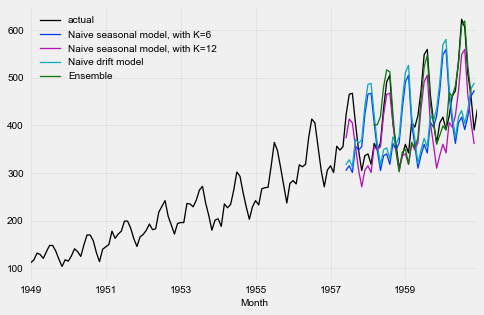

In [22]:
plt.figure(figsize=(8,5))

series.plot(label='actual')
for i, m in enumerate(models):
    model_predictions[i].plot(label=str(m))
    
    # intersect last part, to compare all the methods over the duration of the ensemble forecast
    model_pred = model_predictions[i].slice_intersect(ensemble_pred)
       
    mape_model = mape(series, model_pred)
    print('MAPE Error for {}: {:.2f}%'.format(m, mape_model))

print('MAPE Error ensemble: {:.2f}%'.format(mape(series, ensemble_pred)))

ensemble_pred.plot(label='Ensemble')

print('\nCoefficients of the features time series:')
for i, m in enumerate(models):
    print('Learned coefficient for {}: {:.2f}'.format(m, regr_model.model.coef_[0][i]))
plt.legend();

That's quite nice: by just combining 3 naive models (two seasonal repetitions and a linear trend) using a linear regression, we get a decent-looking ensemble model, which is better than any of the sub-model, with a MAPE of 5.30%.

A couple of interesting things to observe:
* Note how the seasonal model for `K=6` and the naive drift model have an incorrect phase compared to the original signal (due to the original signal having a true seasonality of 12). Despite this, the ensembling is able to learn coefficients that compensate for this effect. Removing either of the two models results in worse performance.
* Note how the regression (ensemble) forecast starts off 12 months after the individual models forecasts -- that is because the regression model needs 12 data points to fit the weights coefficients of the linear regression.

## FFT and RNNs
If you'd like to try models based on Fast Fourier Transform or Recurrent Neural Networks, we recommend that you go over the `FFT-examples.ipynb` and `RNN-examples.ipynb` notebooks, respectively.

## A final word of caution
So is Theta, exponential smoothing, or a linear regression of naive models the best approach for predicting the future number of airline passengers? Well, at this point it's still hard to say exactly which one is best. Our time series is small, and our validation set is even smaller. In such cases, it's very easy to overfit the whole forecasting exercise to such a small validation set. That's especially true if the number of available models and their degrees of freedom is high; so always take results with a grain of salt (especially on small datasets), and apply the scientific method before making any kind of forecast!